In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import h5py
import hdf5plugin

data_path = "/home/panda/rf_data/dataset/raw"
img_path = "/home/panda/rf_data/dataset/img"

dl = DataLoader("/home/panda/rf_data/")

nz = 2048
nx = 256
new_Ns = 2800


device = "cuda"
dtype = torch.float32

In [2]:
df = dl.get_df()
df = df.query("RF == 1 and n_channels == 128")

names = df["name"][:10]

In [ ]:
from deep_bf.wrapper import BenchmarkWrapper
import torch.nn.functional as F
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

beamformer = "MVB"
bfs = [beamformer]

vmin = -60
vmax = 0

norm_factor = 2.0 / (2800 - 1)

pbar = tqdm(names)

for name in pbar:
    pbar.set_description(f"Procesando archivo: {name}°")
    pw = dl.get_defined_pwdata(name, "RF")

    with h5py.File(f"/home/panda/rf_data/dataset/raw/{name}.hdf5", "r") as f:
        rf = f["rf"][:]
        samples_idx = f["samples_idx"][:]


    rf = torch.from_numpy(rf).to(device=device, dtype=dtype)
    samples_idx = torch.from_numpy(samples_idx).to(device=device, dtype=dtype)

    rf = rf.reshape(128, 1, 1, 2800)
    grid = torch.zeros(128, nz, nx, 2, device=device, dtype=dtype)
    grid[..., 0] = samples_idx * norm_factor - 1.0

    selected_samples =  F.grid_sample(
        rf,
        grid,
        mode="bilinear",
        padding_mode="zeros",
        align_corners=True,
    )

    selected_samples = selected_samples.view(128, nz, nx)
    bf = selected_samples.sum(dim=0).cpu()

    Z, X = compute_meshgrid(pw, nz, nx)

    Z = Z.cpu()
    X = X.cpu()

    zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
    xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

    fig = plt.figure(figsize=(6, 8), frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])

    b_mode = get_rf_bmode(bf, vmin, vmax)
    extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

    ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
            extent=extent,
            aspect='equal')
    ax.set_axis_off()
    plt.savefig(f'{img_path}/{name}.png')
    plt.close()


Procesando archivo: TSH234°:   0%|          | 0/1 [00:00<?, ?it/s]

(2048, 256)


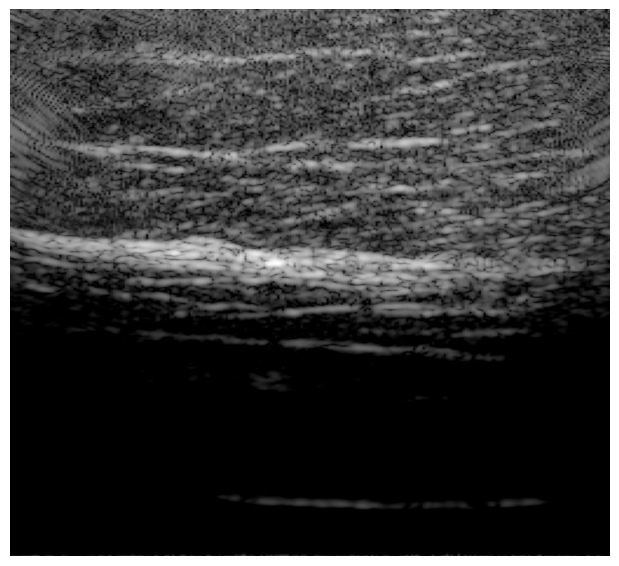

Procesando archivo: TSH234°: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


In [6]:
from deep_bf.wrapper import BenchmarkWrapper
import torch.nn.functional as F
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

df = dl.get_df()
df = df.query("RF == 1 and n_channels == 128")

#names = df["name"][:10]
names = ["TSH234"]

beamformer = "MVB"
bfs = [beamformer]

vmin = -60
vmax = 0

norm_factor = 2.0 / (2800 - 1)

pbar = tqdm(names)

for name in pbar:
    pbar.set_description(f"Procesando archivo: {name}°")
    pw = dl.get_defined_pwdata(name, "RF")

    with h5py.File(f"/home/panda/rf_data/dataset/raw/{name}.hdf5", "r") as f:
        gt = f["ground_truth"][:]
        print(gt.shape)

    Z, X = compute_meshgrid(pw, nz, nx)

    Z = Z.cpu()
    X = X.cpu()

    zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
    xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

    fig = plt.figure(figsize=(6, 8), frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])

    b_mode = get_rf_bmode(gt, vmin, vmax)
    extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

    ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
            extent=extent,
            aspect='equal')
    ax.set_axis_off()
    plt.show()
